<a href="https://colab.research.google.com/github/Dhaneshkp/DesktopAssistant/blob/main/TensorFlow_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

Everst_data=pd.read_csv('Everest_data.csv')
data=Everst_data
data['Attained_age']=data['Age']+data['Duration']
data['Premium_rate']=data['BasePremiumAmount']/data['BaseNARAmount']*10000
exclude_cols = ['Gender','RiskClass']
Coulmns_to_keep=['Attained_age','Premium_rate']
data=data[data['SingleOrJointType']=="Single"]
data=data[data['Gender']=="Male"]
data=data[data['RiskClass']=="NS1"]
data=data[Coulmns_to_keep]
numerical_columns = data.select_dtypes(include=['number']).columns
categorical_columns = data.select_dtypes(include=['object']).columns
data.iloc[4::5, 1] = np.nan
test_data=data.head(1000)
test_data

C:\Users\u013709\AppData\Local\Temp\ipykernel_26952\2702507919.py:6: DtypeWarning: Columns (41) have mixed types. Specify dtype option on import or set low_memory=False.
  Everst_data=pd.read_csv('Everest_data.csv')


,Attained_age,Premium_rate
0,41,3.795200
2,53,9.488000
4,59,22.345600
8,49,12.331262
9,60,NaN
...,...,...
1424,67,53.121600
1425,46,6.851740
1427,30,3.580196
1428,48,7.422906


In [78]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
#!pip install pytorch-ignite
from ignite.engine import Engine, Events
from ignite.metrics import MeanSquaredError
from sklearn.preprocessing import PolynomialFeatures
# ...

def weighted_mse_loss(input, target, weight):
    return torch.mean(weight * (input - target) ** 2)

# Example data generation function
def generate_data(num_samples=1000):
    np.random.seed(0)
    age = np.random.randint(20, 60, size=num_samples)
    duration = np.random.randint(1, 20, size=num_samples)
    risk_class = np.random.randint(0, 3, size=num_samples)
    client_plan = np.random.randint(0, 4, size=num_samples)
    premium_rate = age * 10 + duration * 0.05 + risk_class * 1.5 + client_plan * 0.2 + np.random.normal(0, 1, size=num_samples)/100

    data = pd.DataFrame({
        'Attained_age': age,
        'duration': duration,
        'risk_class': risk_class,
        'client_plan': client_plan,
        'Premium_rate': premium_rate
    })

    # Introduce random missing values in premium_rate
    missing_indices = np.random.choice(num_samples, size=int(0.1 * num_samples), replace=False)
    data.loc[missing_indices, 'Premium_rate'] = np.nan

    return data

# Data Preparation
data = generate_data()
features = data[['Attained_age']].values
premium_rates = data['Premium_rate'].values

# Normalize features and target
scaler_X = StandardScaler()
scaler_y = StandardScaler()
features = scaler_X.fit_transform(features)
premium_rates = premium_rates.reshape(-1, 1)
premium_rates = scaler_y.fit_transform(premium_rates).reshape(-1)

# Create mask for missing values
mask = ~np.isnan(premium_rates)
premium_rates[~mask] = 0  # Replace NaNs with zeros for now

# Convert to tensors
features = torch.tensor(features, dtype=torch.float32)
premium_rates = torch.tensor(premium_rates, dtype=torch.float32).unsqueeze(1)
mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(1)

# Train a simple linear regression model
poly = PolynomialFeatures(degree=2)
features_poly = features[mask.squeeze().bool()]#poly.fit_transform(features[mask.squeeze().bool()])
lin_reg = LinearRegression()
lin_reg.fit(features_poly, premium_rates[mask.squeeze().bool()])
lin_reg_predictions = lin_reg.predict(features)#poly.fit_transform(features))
#print(scaler_y.inverse_transform(lin_reg_predictions))
class Generator(nn.Module):
    def __init__(self, feature_dim, target_dim):
        super(Generator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(feature_dim + target_dim, 64),  # Increased neurons
            nn.LeakyReLU(0.2),  # LeakyReLU activation
            #nn.Linear(256, 128),
            #nn.LeakyReLU(0.2),
            nn.Linear(64, target_dim),
            #nn.ReLU()  # Ensure non-negative outputs
        )

    def forward(self, x, noise):
        input_combined = torch.cat((x, noise), dim=1)
        return self.fc(input_combined)

class Discriminator(nn.Module):
    def __init__(self, feature_dim, target_dim):
        super(Discriminator, self).__init__()
        self.linear = nn.Linear(feature_dim, target_dim)  # Linear regression layer
        self.fc = nn.Sequential(
            nn.Linear(feature_dim + target_dim + target_dim, 64),
            nn.LeakyReLU(0.2),
            #nn.Linear(256, 128),
            #nn.LeakyReLU(0.2),
            #nn.Linear(128, 64),  # Additional layer
            #nn.LeakyReLU(0.2),
            nn.Linear(64, 1)
        )

    def forward(self, x, y):
        linear_prediction = self.linear(x)  # Linear regression prediction
        input_combined = torch.cat((x, y, linear_prediction), dim=1)  # Include prediction
        return self.fc(input_combined)

# Initialize models
feature_dim = features.shape[1]
target_dim = 1  # Premium rate is a single value
generator = Generator(feature_dim, target_dim)
discriminator = Discriminator(feature_dim, target_dim)

# Optimizers
g_optimizer = optim.Adam(generator.parameters(), lr=0.21, betas=(0.5, 0.999))  # Increased
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.21, betas=(0.5, 0.999))

# Loss functions
reconstruction_loss = nn.MSELoss()
regression_loss = nn.MSELoss()

# Gradient penalty
def compute_gradient_penalty(discriminator, real_samples, fake_samples, real_features):
    alpha = torch.rand(real_samples.size(0), 1)
    alpha = alpha.expand(real_samples.size()).to(real_samples.device)

    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    d_interpolates = discriminator(real_features, interpolates)

    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=torch.ones(d_interpolates.size()).to(real_samples.device),
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]

    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

weights = torch.ones_like(premium_rates)
weights[~mask.squeeze().bool()] = 1  # Adjust weight as needed
# Training loop
num_epochs = 1000
batch_size = 1000
lambda_gp = 10  # Gradient penalty coefficient
critic_iterations = 25  # Number of discriminator updates per generator update

for epoch in range(num_epochs):
    for _ in range(critic_iterations):
        # Generate fake data
        noise = torch.randn(batch_size, target_dim)

        # Create batches (replace with your data loading logic)
        batch_indices = np.random.choice(len(features), batch_size, replace=False)
        real_features = features[batch_indices]
        real_premium_rates = premium_rates[batch_indices]
        batch_mask = mask[batch_indices]
        lin_reg_preds = torch.tensor(lin_reg_predictions[batch_indices], dtype=torch.float32).unsqueeze(1)
        #if epoch == 500 or epoch == 990:
        #    print(lin_reg_predictions)
        # Generate fake targets using the generator
        lin_reg_preds_tensor = torch.tensor(lin_reg.predict(real_features), dtype=torch.float32)#lin_reg.predict(poly.fit_transform(real_features)), dtype=torch.float32)
        combined_input = lin_reg_preds_tensor + noise
        fake_premium_rates = generator(real_features, combined_input)


        # Combine real and fake targets using the mask
        combined_premium_rates = batch_mask * real_premium_rates + (1 - batch_mask) * fake_premium_rates

        # Train Discriminator
        d_optimizer.zero_grad()

        real_validity = discriminator(real_features, real_premium_rates)
        fake_validity = discriminator(real_features, combined_premium_rates.detach())

        gradient_penalty = compute_gradient_penalty(discriminator, real_premium_rates, combined_premium_rates, real_features)
        d_loss = -torch.mean(real_validity) + torch.mean(fake_validity) + lambda_gp * gradient_penalty

        d_loss.backward()
        d_optimizer.step()

    # Train Generator
    g_optimizer.zero_grad()

    noise = torch.randn(batch_size, target_dim)
    lin_reg_preds_tensor = torch.tensor(lin_reg.predict(real_features), dtype=torch.float32)#poly.fit_transform(real_features)), dtype=torch.float32)
    combined_input =  lin_reg_preds_tensor + noise
    fake_premium_rates = generator(real_features, combined_input)
    combined_premium_rates = batch_mask * real_premium_rates + (1 - batch_mask) * fake_premium_rates
    #lin_reg_preds=batch_mask * real_premium_rates+(1 - batch_mask) * lin_reg_preds
    g_loss_adv = -torch.mean(discriminator(real_features, combined_premium_rates))
    g_loss_recon = reconstruction_loss(combined_premium_rates, real_premium_rates)
    g_loss_reg = weighted_mse_loss(combined_premium_rates, lin_reg_preds, weights[batch_indices])
    g_loss = g_loss_adv + g_loss_recon + g_loss_reg

    g_loss.backward()
    g_optimizer.step()

    if epoch % 100== 0:
        print(f'Epoch [{epoch}/{num_epochs}], d_loss: {d_loss.item()}, g_loss: {g_loss.item()}')

# Use the trained generator for imputation
noise = torch.randn(len(features), target_dim)
lin_reg_preds_tensor = torch.tensor(lin_reg.predict(features), dtype=torch.float32)
combined_input = lin_reg_preds_tensor + noise
imputed_premium_rates = generator(features, combined_input).detach().numpy()
#imputed_premium_rates = mask.numpy() * premium_rates.numpy() + (1 - mask.numpy()) * imputed_premium_rates

# Denormalize the imputed values
imputed_premium_rates = scaler_y.inverse_transform(imputed_premium_rates)

# Replace the original missing values with the imputed values
data['imputed_premium_rate'] = imputed_premium_rates
data


Epoch [0/1000], d_loss: 0.49154067039489746, g_loss: 0.5737324953079224
Epoch [100/1000], d_loss: 0.05560051649808884, g_loss: -3.8120439052581787
Epoch [200/1000], d_loss: 0.3271157145500183, g_loss: -2639.510498046875
Epoch [300/1000], d_loss: 0.030992433428764343, g_loss: -2579.102783203125
Epoch [400/1000], d_loss: 0.025405269116163254, g_loss: -2303.957763671875
Epoch [500/1000], d_loss: 1.897630214691162, g_loss: -1864.6094970703125
Epoch [600/1000], d_loss: 0.03516421467065811, g_loss: -3316.760009765625
Epoch [700/1000], d_loss: 89.06489562988281, g_loss: -3122.0615234375
Epoch [800/1000], d_loss: 0.025306077674031258, g_loss: -1817.3170166015625
Epoch [900/1000], d_loss: 0.02500944770872593, g_loss: -1061.2060546875


,Attained_age,duration,risk_class,client_plan,Premium_rate,imputed_premium_rate
0,20,5,2,0,203.258701,355.236694
1,23,2,2,2,233.506539,351.672943
2,23,18,2,0,233.886830,336.062653
3,59,18,0,3,591.509450,350.558441
4,29,17,0,2,NaN,351.645660
...,...,...,...,...,...,...
995,31,6,0,0,310.302370,353.460938
996,33,9,0,0,330.453733,354.479645
997,49,6,1,3,NaN,357.148926
998,51,5,1,0,511.759308,356.600037


Text(0, 0.5, 'Imputed Premium Rate')

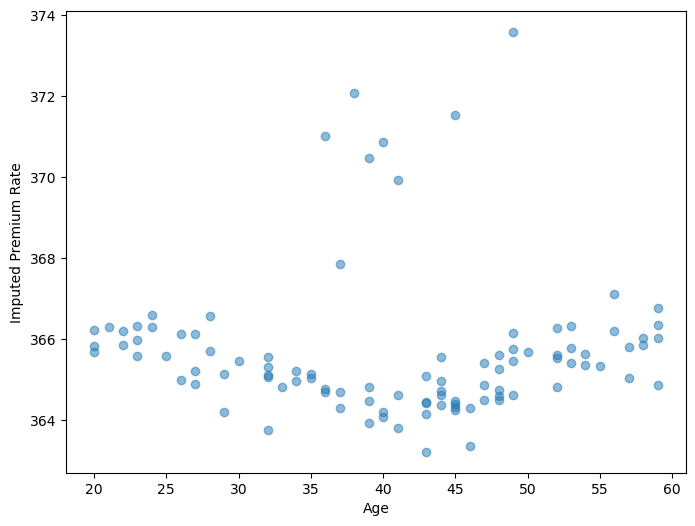

In [77]:
# @title Comparison of Premium Rates: Actual vs. Imputed

import matplotlib.pyplot as plt
data_imputed=data[data['Premium_rate'].isnull()]
plt.figure(figsize=(8, 6))
plt.scatter(data_imputed['Attained_age'], data_imputed['imputed_premium_rate'], alpha=0.5)
plt.xlabel('Age')
plt.ylabel('Imputed Premium Rate')


In [4]:
import sklearn.metrics as metrics

lin_reg = LinearRegression()
lin_reg.fit(features[mask.squeeze().bool()], premium_rates[mask.squeeze().bool()])
lin_reg_predictions = lin_reg.predict(features)

# Calculate Mean Squared Error (MSE) as Loss
mse_loss = metrics.mean_squared_error(premium_rates[mask.squeeze().bool()], lin_reg_predictions[mask.squeeze().bool()])

# Calculate R-squared (R2) score
r2_score = metrics.r2_score(premium_rates[mask.squeeze().bool()], lin_reg_predictions[mask.squeeze().bool()])

print("MSE Loss:", mse_loss)
print("R2 Score:", r2_score)

MSE Loss: 0.4059527
R2 Score: 0.5940473375098508
